In [30]:
import pandas as pd
from sklearn.cluster import KMeans, SpectralClustering, DBSCAN
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.svm import OneClassSVM
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_samples, silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.cm as cm
from scipy import stats
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [31]:
df = pd.read_csv("labeled_data_above.csv")

In [32]:
df = df.drop(df.columns[:1], axis=1)

In [33]:
columns = df.columns.tolist()

In [78]:
def scatter_plot_with_labels(x, y, clustering_labels, x_label, y_label, y_lim = None, x_lim = None,  title = None):
    cluster_colors = ['#440154','#31688e','#35b779','#fde725']
    scatter = plt.scatter(x, y, c=[cluster_colors[label] for label in clustering_labels])
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    if y_lim:
        plt.ylim(y_lim)

    if x_lim:
        plt.xlim(x_lim)

    # Get unique labels and their corresponding colors from the scatter plot
    unique_labels = list(set(clustering_labels))
    legend_elements = []
    for label in unique_labels:
        color = cluster_colors[label]
        legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', label=f"Label {label}", markerfacecolor=color, markersize=8))

    # Create the legend
    plt.legend(handles=legend_elements, loc='best')


    plt.show()

In [35]:
not_feature_column = ['GEM phase ID', 'Country', 'Status', 'Latitude', 'Longitude', 'threshold']
features = ['smoothness', 'average_elevation']


In [36]:
param_columns_monthly = [column for column in df.columns if 'average' in column and 'monthly' in column and not 'radiation' in column and not 'PM1' in column]
param_columns_full = [column for column in df.columns if 'full' in column and not 'radiation' in column and not 'PM1' in column]
param_columns = [column for column in df.columns if 'average' in column and not 'radiation' in column and not 'sun' in column ]
param_columns_var = [column for column in df.columns if 'variance' in column and not 'radiation' in column and not 'sun' in column]
param_columns_stdev = [column for column in df.columns if 'standard_deviation' in column and not 'radiation' in column and not 'sun' in column]
param_columns_max_temp = [column for column in df.columns if 'max' in column and 'temperature' in column]

In [37]:
#features.extend(param_columns_monthly)
features.extend(param_columns_full)
#features.extend(param_columns)
#features.extend(param_columns_var)
#features.extend(param_columns_stdev)
#features.extend(param_columns_max_temp)

In [38]:
df_above_good = df[df['labels'].isin([2])].copy()
df_above_good.dropna(subset=features, inplace=True)
df_above_bad = df[df['labels'].isin([0,1,3])].copy()
df_above_bad.dropna(subset=features, inplace=True)

df_normalized = df.copy()
df_above_good_normalized = df_above_good.copy()
df_above_bad_normalized = df_above_bad.copy()

df_normalized[features] = MinMaxScaler().fit_transform(df_normalized[features])
df_above_good_normalized[features] = MinMaxScaler().fit_transform(df_above_good[features])
df_above_bad_normalized[features] = MinMaxScaler().fit_transform(df_above_bad[features])

In [11]:
test_df = df_normalized[features][df['labels'].isin([2,3])]

In [89]:
model = OneClassSVM(kernel='rbf', nu=0.01, gamma=0.0001)
model.fit(df_normalized[features][df['labels'].isin([2])])

x_predicted = model.predict(df_normalized[features][df_normalized['labels'].isin([2])])
y_predicted = model.predict(df_normalized[features][df_normalized['labels'].isin([0,1,3])])

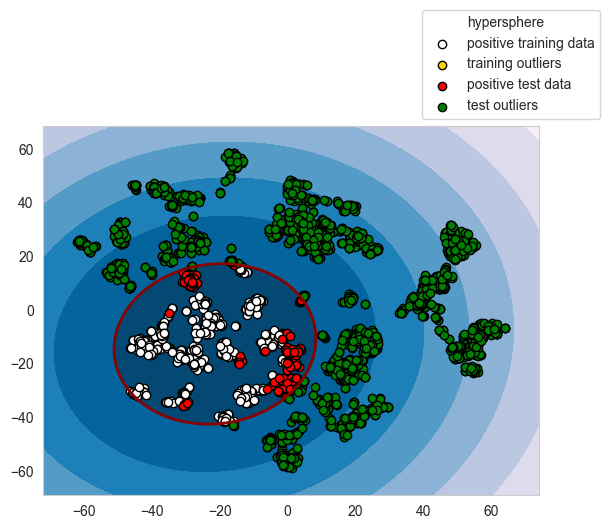

In [92]:
full_reduced = TSNE(n_components=2, random_state=42).fit_transform(df_normalized[features])

# fit the model to the reduced data
#svm = OneClassSVM(kernel='rbf', nu=0.01, gamma=0.001)
svm = OneClassSVM(kernel='rbf', nu=0.001, gamma=0.0001)
svm.fit(full_reduced[df_normalized['labels'].isin([2])])

x_predicted = svm.predict(full_reduced[df_normalized['labels'].isin([2])])
y_predicted = svm.predict(full_reduced[df_normalized['labels'].isin([0,1,3])])
#full_predicted = svm.predict(full_reduced)

x_min, x_max = full_reduced[:, 0].min() - 10, full_reduced[:, 0].max() + 10
y_min, y_max = full_reduced[:, 1].min() - 10, full_reduced[:, 1].max() + 10

x_ = np.linspace(x_min, x_max, 500)
y_ = np.linspace(y_min, y_max, 500)

xx, yy = np.meshgrid(x_, y_)

# evaluate the decision function on the meshgrid
z = svm.decision_function(np.c_[xx.ravel(), yy.ravel()])
z = z.reshape(xx.shape)

# plot the decision function and the reduced data
plt.contourf(xx, yy, z, cmap=plt.cm.PuBu)
a = plt.contour(xx, yy, z, levels=[0], linewidths=2, colors='darkred')
b = plt.scatter(full_reduced[df_normalized['labels'].isin([2])][x_predicted == 1, 0], full_reduced[df_normalized['labels'].isin([2])][x_predicted == 1, 1], c='white', edgecolors='k')
c = plt.scatter(full_reduced[df_normalized['labels'].isin([2])][x_predicted == -1, 0], full_reduced[df_normalized['labels'].isin([2])][x_predicted == -1, 1], c='gold', edgecolors='k')
d = plt.scatter(full_reduced[df_normalized['labels'].isin([0,1,3])][y_predicted == 1, 0], full_reduced[df_normalized['labels'].isin([0,1,3])][y_predicted == 1, 1], c='red', edgecolors='k')
e = plt.scatter(full_reduced[df_normalized['labels'].isin([0,1,3])][y_predicted == -1, 0], full_reduced[df_normalized['labels'].isin([0,1,3])][y_predicted == -1, 1], c='green', edgecolors='k')
plt.legend([a.collections[0], b, c, d, e], ['hypersphere', 'positive training data', 'training outliers', 'positive test data', 'test outliers'], bbox_to_anchor=(0.75, 1))
plt.axis('tight')
plt.show()

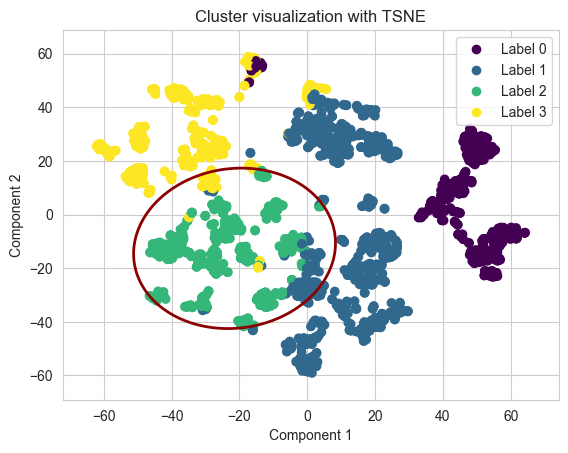

In [79]:
a = plt.contour(xx, yy, z, levels=[0], linewidths=2, colors='darkred')
scatter_plot_with_labels(full_reduced[:, 0], full_reduced[:, 1], df['labels'], 'Component 1', 'Component 2', title = 'Cluster visualization with TSNE')

In [85]:
df_above_bad['classes'] = y_predicted
df_above_good['classes'] = x_predicted
df_above = pd.concat([df_above_good,df_above_bad])

In [86]:
df_above[not_feature_column + features + ['classes'] + ['labels']].to_csv("classified_data_above.csv")

In [70]:
df_above_positive = df_above[df_above['classes'] == 1].copy()

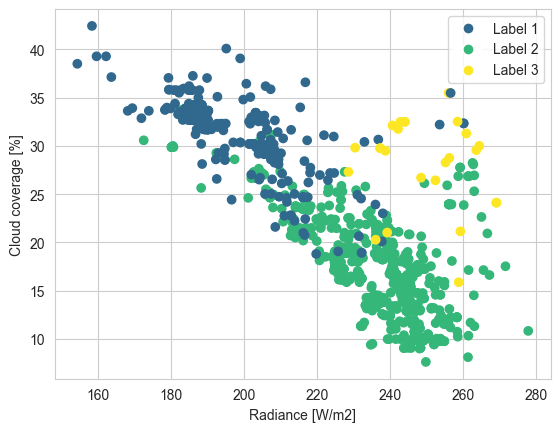

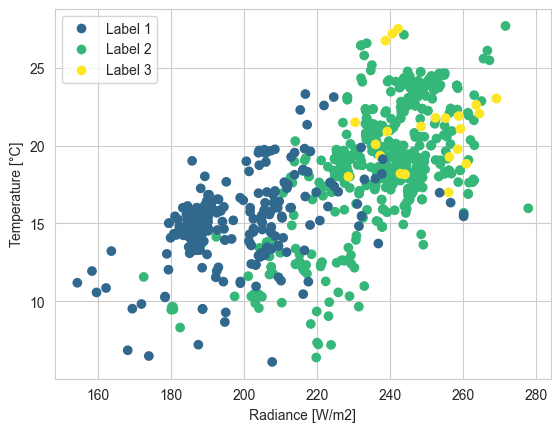

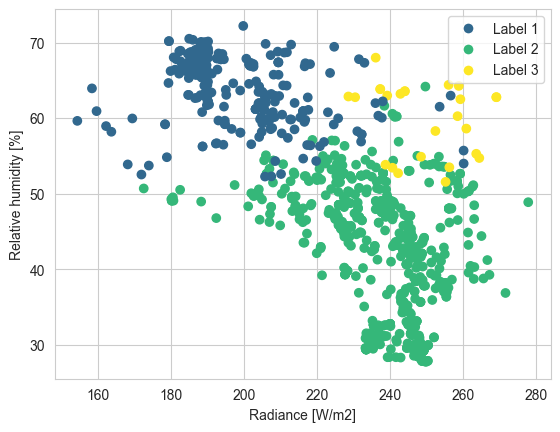

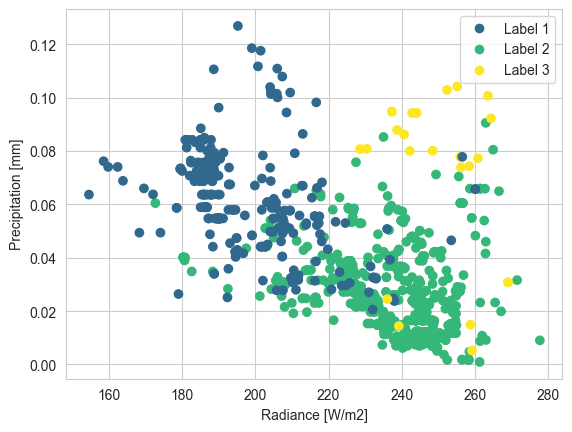

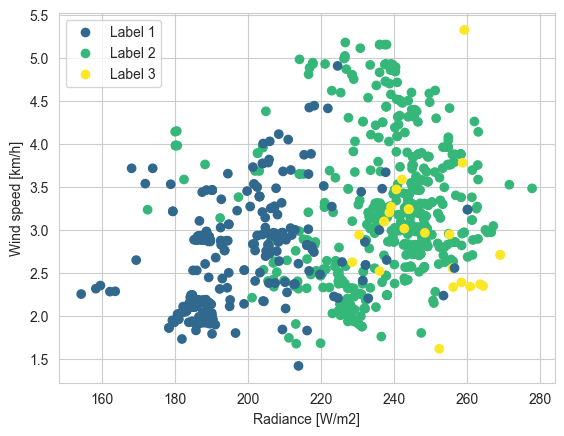

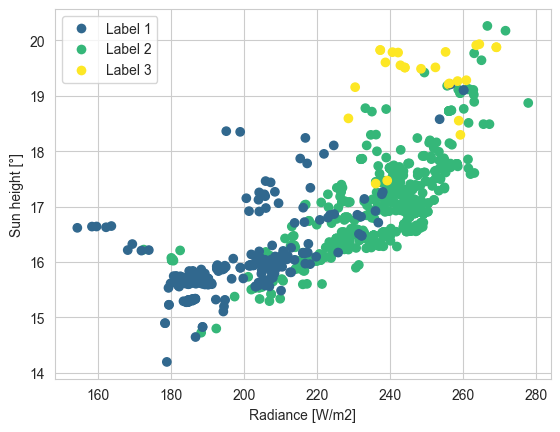

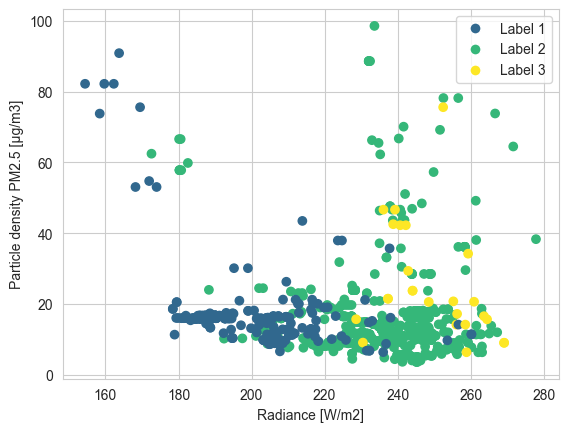

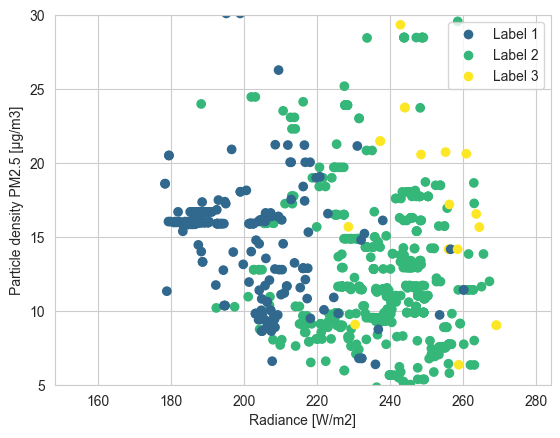

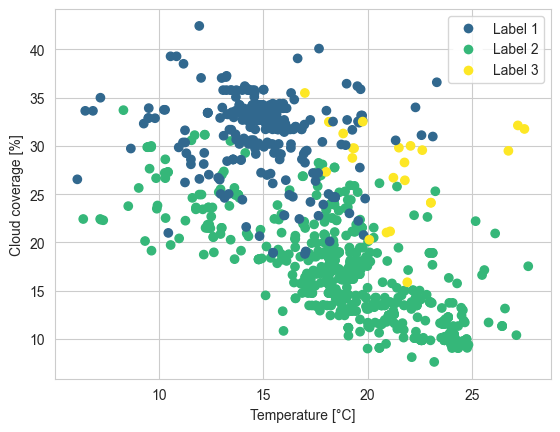

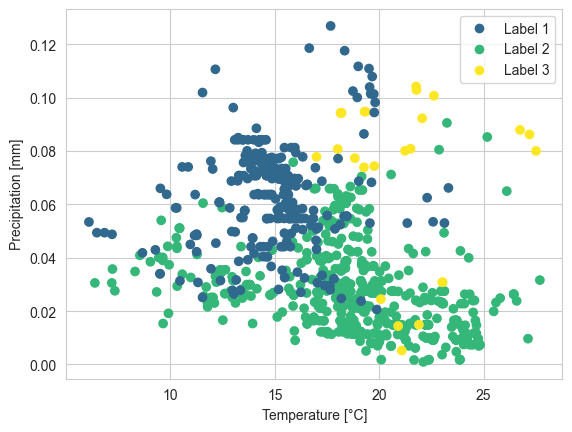

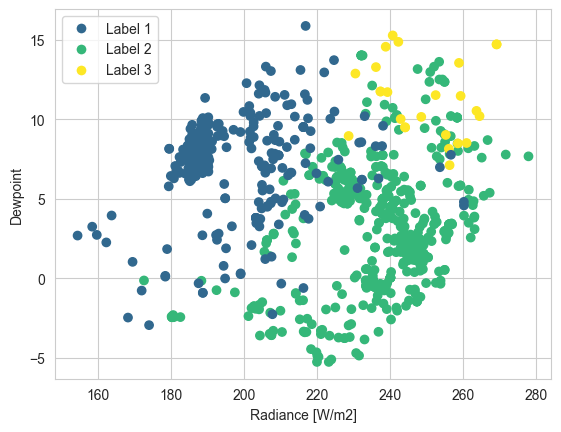

In [88]:
scatter_plot_with_labels(df_above_positive[features]['full_radiance_average'], df_above_positive[features]['full_cloudcover_average'], df_above_positive['labels'], 'Radiance [W/m2]', 'Cloud coverage [%]')
scatter_plot_with_labels(df_above_positive[features]['full_radiance_average'], df_above_positive[features]['full_temperature_average'], df_above_positive['labels'], 'Radiance [W/m2]', 'Temperature [°C]')
scatter_plot_with_labels(df_above_positive[features]['full_radiance_average'], df_above_positive[features]['full_relativehumidity_2m_average'], df_above_positive['labels'], 'Radiance [W/m2]', 'Relative humidity [%]')
scatter_plot_with_labels(df_above_positive[features]['full_radiance_average'], df_above_positive[features][['full_precipitation_average']], df_above_positive['labels'], 'Radiance [W/m2]', 'Precipitation [mm]')
scatter_plot_with_labels(df_above_positive[features]['full_radiance_average'], df_above_positive[features]['full_wind_speed_average'], df_above_positive['labels'], 'Radiance [W/m2]', 'Wind speed [km/h]')
scatter_plot_with_labels(df_above_positive[features]['full_radiance_average'], df_above_positive[features]['full_sun_height_average'], df_above_positive['labels'], 'Radiance [W/m2]', 'Sun height [°]')
scatter_plot_with_labels(df_above_positive[features]['full_radiance_average'], df_above_positive[features]['full_PM2.5_average'], df_above_positive['labels'], 'Radiance [W/m2]', 'Particle density PM2.5 [µg/m3]')
scatter_plot_with_labels(df_above_positive[features]['full_radiance_average'], df_above_positive[features]['full_PM2.5_average'], df_above_positive['labels'], 'Radiance [W/m2]', 'Particle density PM2.5 [µg/m3]', y_lim=(5,30))
scatter_plot_with_labels(df_above_positive[features]['full_temperature_average'], df_above_positive[features]['full_cloudcover_average'], df_above_positive['labels'], 'Temperature [°C]', 'Cloud coverage [%]')
scatter_plot_with_labels(df_above_positive[features]['full_temperature_average'], df_above_positive[features]['full_precipitation_average'], df_above_positive['labels'], 'Temperature [°C]', 'Precipitation [mm]')
scatter_plot_with_labels(df_above_positive[features]['full_radiance_average'], df_above_positive[features]['full_dewpoint_2m_average'], df_above_positive['labels'], 'Radiance [W/m2]', 'Dewpoint')

In [90]:
df_below = pd.read_csv("labeled_data_below.csv")

In [91]:
df_below_good = df_below[df_below['labels'].isin([2])].copy()
df_below_good.dropna(subset=features, inplace=True)
df_below_bad = df_below[df_below['labels'].isin([0,1,3])].copy()
df_below_bad.dropna(subset=features, inplace=True)

df_below_normalized = df_below.copy()
df_below_good_normalized = df_below_good.copy()
df_below_bad_normalized = df_below_bad.copy()

df_below_normalized[features] = MinMaxScaler().fit_transform(df_below_normalized[features])
df_below_good_normalized[features] = MinMaxScaler().fit_transform(df_below_good[features])
df_below_bad_normalized[features] = MinMaxScaler().fit_transform(df_below_bad[features])

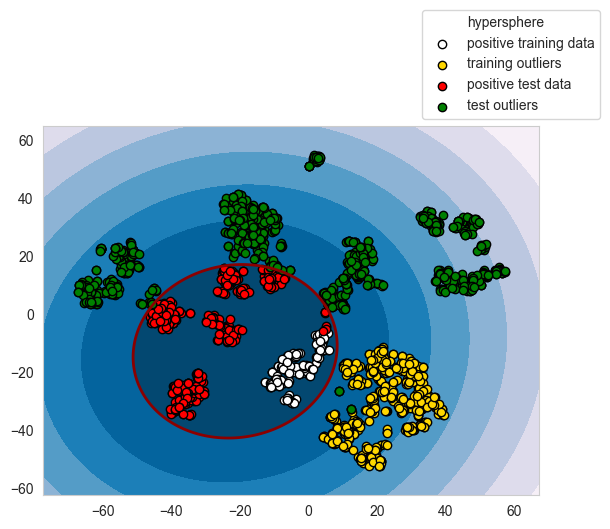

In [93]:
full_reduced = TSNE(n_components=2, random_state=42).fit_transform(df_below_normalized[features])

x_predicted = svm.predict(full_reduced[df_below_normalized['labels'].isin([2])])
y_predicted = svm.predict(full_reduced[df_below_normalized['labels'].isin([0,1,3])])
#full_predicted = svm.predict(full_reduced)

x_min, x_max = full_reduced[:, 0].min() - 10, full_reduced[:, 0].max() + 10
y_min, y_max = full_reduced[:, 1].min() - 10, full_reduced[:, 1].max() + 10

x_ = np.linspace(x_min, x_max, 500)
y_ = np.linspace(y_min, y_max, 500)

xx, yy = np.meshgrid(x_, y_)

# evaluate the decision function on the meshgrid
z = svm.decision_function(np.c_[xx.ravel(), yy.ravel()])
z = z.reshape(xx.shape)

# plot the decision function and the reduced data
plt.contourf(xx, yy, z, cmap=plt.cm.PuBu)
a = plt.contour(xx, yy, z, levels=[0], linewidths=2, colors='darkred')
b = plt.scatter(full_reduced[df_below_normalized['labels'].isin([2])][x_predicted == 1, 0], full_reduced[df_below_normalized['labels'].isin([2])][x_predicted == 1, 1], c='white', edgecolors='k')
c = plt.scatter(full_reduced[df_below_normalized['labels'].isin([2])][x_predicted == -1, 0], full_reduced[df_below_normalized['labels'].isin([2])][x_predicted == -1, 1], c='gold', edgecolors='k')
d = plt.scatter(full_reduced[df_below_normalized['labels'].isin([0,1,3])][y_predicted == 1, 0], full_reduced[df_below_normalized['labels'].isin([0,1,3])][y_predicted == 1, 1], c='red', edgecolors='k')
e = plt.scatter(full_reduced[df_below_normalized['labels'].isin([0,1,3])][y_predicted == -1, 0], full_reduced[df_below_normalized['labels'].isin([0,1,3])][y_predicted == -1, 1], c='green', edgecolors='k')
plt.legend([a.collections[0], b, c, d, e], ['hypersphere', 'positive training data', 'training outliers', 'positive test data', 'test outliers'], bbox_to_anchor=(0.75, 1))
plt.axis('tight')
plt.show()

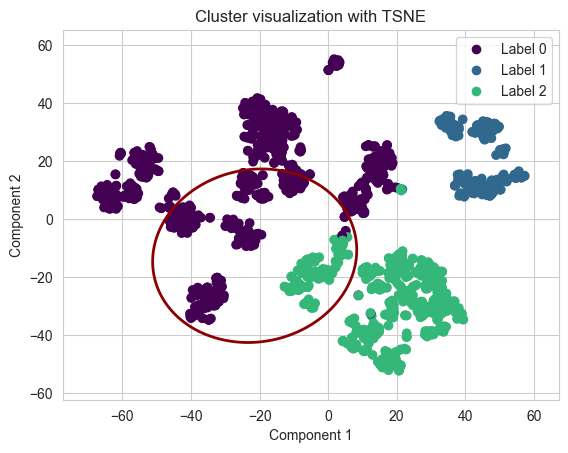

In [95]:
a = plt.contour(xx, yy, z, levels=[0], linewidths=2, colors='darkred')
scatter_plot_with_labels(full_reduced[:, 0], full_reduced[:, 1], df_below['labels'], 'Component 1', 'Component 2', title = 'Cluster visualization with TSNE')